In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from utils.data import get_dataset_paths
from utils.data import Marconi100Dataset
from utils.data import UnfoldedDataset
from utils.metrics import compute_metrics
from utils.modutils import load_model

from algos.deep_fib.core import get_masks
from algos.deep_fib.core import residual_error
from algos.deep_fib.core import DeepFIBEngine
from algos.deep_fib.sci_net import SCINet

plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
test_loader = DataLoader(
    UnfoldedDataset(
        Marconi100Dataset(
            train_test_split(
                get_dataset_paths("../data"), test_size=0.1, random_state=42
            )[1],
            scaling="minmax",
        ),
        horizon=1024,
        stride=512,
    ),
    batch_size=32,
    shuffle=False,
)
print(len(test_loader))

Loading: 100%|██████████| 25/25 [00:59<00:00,  2.37s/it]

21


In [4]:
def get_model(run: str, epoch: int) -> SCINet:
    cfg_path = f"./outputs/{run}/config.json"
    model_path = f"./outputs/{run}/models/model_{epoch}.pth"

    with open(cfg_path, "r") as f:
        config = json.load(f)

    print(config)
    model = SCINet(**config).float()

    load_model(model, model_path, device)
    return model

In [5]:
def get_predictions(model: SCINet) -> "tuple[torch.Tensor, torch.Tensor]":
    with torch.no_grad():
        model.eval()

        _all_errors = []
        _all_labels = []

        for batch in tqdm(test_loader):
            inputs = batch["data"].to(device)
            targets = inputs.detach().clone()

            preds = model(inputs)

            labels = batch["label"]
            errors = residual_error(preds, targets)

            _all_errors.append(errors.cpu())
            _all_labels.append(labels)

        all_errors = torch.concat(_all_errors)
        all_labels = torch.concat(_all_labels)

        print(all_errors.size(), all_labels.size())
    return all_errors, all_labels

In [16]:
def evaluate_thresholds(
    all_errors: torch.Tensor, all_labels: torch.Tensor
) -> "dict[str, list[float]]":
    step = 0.001
    thresholds = np.arange(0, all_errors.max() + step, step)

    f1 = []
    precision = []
    recall = []
    tp = []
    fp = []
    fn = []
    for at in thresholds:
        labels = (all_errors > at).to(torch.int)
        metrics = compute_metrics(labels.flatten(), all_labels.flatten())
        f1.append(metrics["f1"])
        precision.append(metrics["precision"])
        recall.append(metrics["recall"])
        tp.append(metrics["true_positive"])
        fp.append(metrics["false_positive"])
        fn.append(metrics["false_negative"])

    axes: "tuple[tuple[plt.Axes, ...], ...]"
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # type: ignore
    axes[0][0].set_title("F1")
    axes[0][0].plot(thresholds, f1)
    axes[0][0].set_xlabel("thresholds")

    axes[0][1].set_title("Precision")
    axes[0][1].plot(thresholds, precision)
    axes[0][1].set_xlabel("thresholds")

    axes[0][2].set_title("Recall")
    axes[0][2].plot(thresholds, recall)
    axes[0][2].set_xlabel("thresholds")

    axes[1][0].set_title("True Positives")
    axes[1][0].plot(thresholds, tp)
    axes[1][0].set_xlabel("thresholds")

    axes[1][1].set_title("False Positives")
    axes[1][1].plot(thresholds, fp)
    axes[1][1].set_xlabel("thresholds")

    axes[1][2].set_title("False Negatives")
    axes[1][2].plot(thresholds, fn)
    axes[1][2].set_xlabel("thresholds")

    plt.show()
    return dict(
        thresholds=list(thresholds),
        f1=f1,
        precision=precision,
        recall=recall,
        true_positive=tp,
        false_positive=fp,
        false_negative=fn,
    )


In [7]:
errs_0, labs_0 = get_predictions(get_model("deep_fib_low_lr", 29))

{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.5}


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]

torch.Size([647, 1024]) torch.Size([647, 1024])


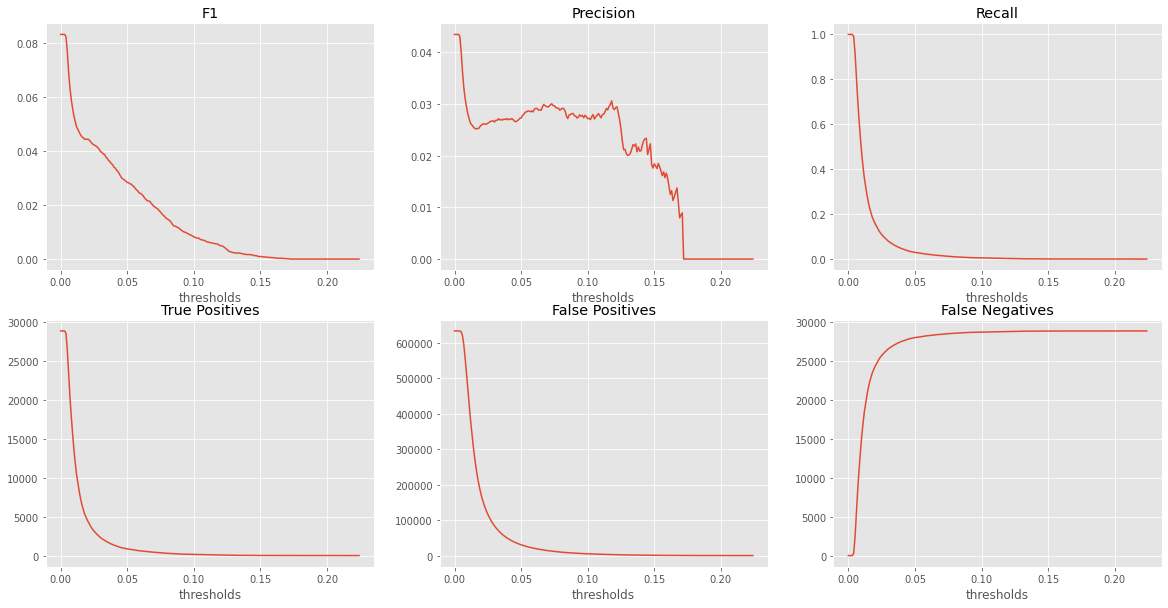

In [17]:
metrics_0 = evaluate_thresholds(errs_0, labs_0)

In [14]:
errs_1, labs_1 = get_predictions(get_model("deep_fib_less_masks", 29))

{'output_len': 1024, 'input_len': 1024, 'num_encoder_levels': 3, 'hidden_decoder_sizes': [512], 'input_dim': 460, 'hidden_size': 2, 'kernel_size': 3, 'dropout': 0.05}


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]

torch.Size([647, 1024]) torch.Size([647, 1024])


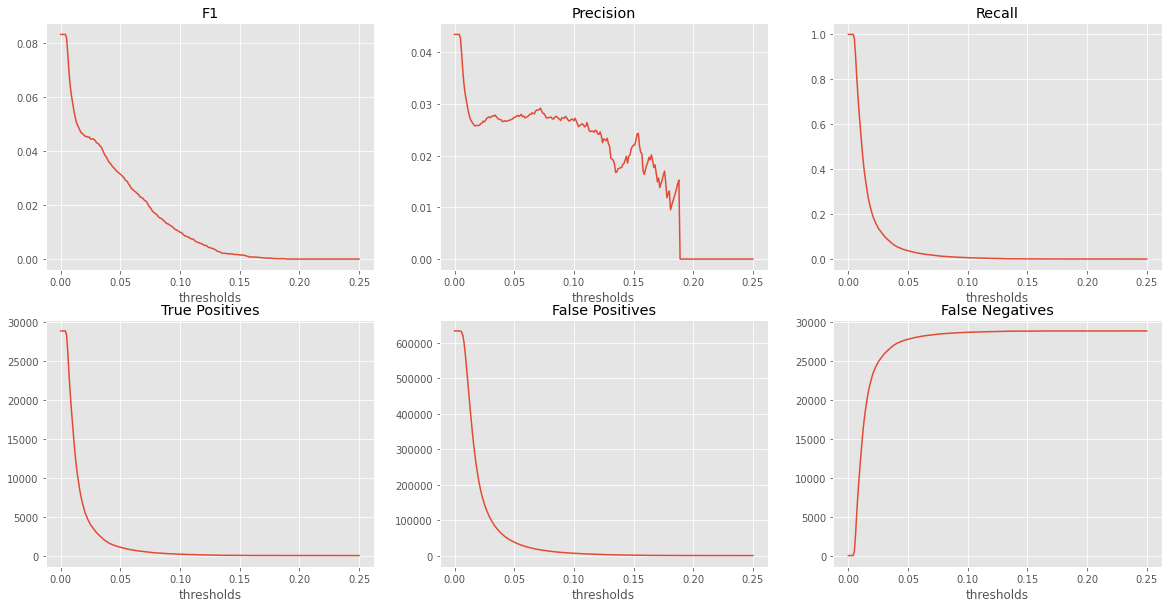

In [18]:
metrics_1 = evaluate_thresholds(errs_1, labs_1)